## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [ ]:
# Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [2]:
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    For train/val: loads images and labels in correct order.
    For test: loads images in filename order, labels is empty.
    """
    images = []
    labels = []
    # Check if subfolders exist (train/val) or just images (test)
    if any(os.path.isdir(os.path.join(set_dir, d)) for d in os.listdir(set_dir)):
        # train/val: subfolders are class names
        class_names = sorted(os.listdir(set_dir))
        for class_name in class_names:
            class_path = os.path.join(set_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            img_files = sorted(os.listdir(class_path))
            for img_file in img_files:
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
    else:
        # test: images directly in set_dir, sorted by filename
        img_files = sorted(os.listdir(set_dir), key=lambda x: int(os.path.splitext(x)[0]))
        for img_file in img_files:
            img_path = os.path.join(set_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
        labels = []
    return images, labels

In [ ]:
# 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    for img in images:
        h, w = img.shape[:2]
        # Scale the image while maintaining aspect ratio
        if h < w:
            new_h = target_size
            new_w = int(w * target_size / h)
        else:
            new_w = target_size
            new_h = int(h * target_size / w)
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        # Center crop to target_size
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped = resized[start_y:start_y+target_size, start_x:start_x+target_size]
        processed_images.append(cropped)
    return np.stack(processed_images)


In [4]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [5]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [ ]:
# 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [ ]:
# 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(np.transpose(images_train, (0, 3, 1, 2)))
tensor_val = torch.from_numpy(np.transpose(images_val, (0, 3, 1, 2)))
tensor_test = torch.from_numpy(np.transpose(images_test, (0, 3, 1, 2)))

In [ ]:
# 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# Calculate mean and std for each channel using the training set
train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

# Normalize the tensors using the computed mean and std
tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std

In [ ]:
# 6. Save the pre-processed sets as .pt files.
import pickle

save_dir = os.path.abspath(os.path.join(os.getcwd(), '../data_preprocessed'))
os.makedirs(save_dir, exist_ok=True)

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, os.path.join(save_dir, 'tensor_train.pt'))
torch.save(tensor_val, os.path.join(save_dir, 'tensor_val.pt'))
torch.save(tensor_test, os.path.join(save_dir, 'tensor_test.pt'))

# 6.2 Create a list to map index to label and a dictionary to map label to index.
unique_labels = sorted(set(labels_train))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[l] for l in labels_train], dtype=torch.long)
labels_val_index = torch.tensor([label_to_index[l] for l in labels_val], dtype=torch.long)

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, os.path.join(save_dir, 'labels_train.pt'))
torch.save(labels_val_index, os.path.join(save_dir, 'labels_val.pt'))
with open(os.path.join(save_dir, 'label_to_index.pkl'), 'wb') as f:
    pickle.dump(label_to_index, f)
with open(os.path.join(save_dir, 'index_to_label.pkl'), 'wb') as f:
    pickle.dump(index_to_label, f)


In [ ]:
# 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.
save_dir = os.path.abspath(os.path.join(os.getcwd(), '../data_preprocessed'))

tensor_train = torch.load(os.path.join(save_dir, 'tensor_train.pt'), weights_only=True)
tensor_val = torch.load(os.path.join(save_dir, 'tensor_val.pt'), weights_only=True)
tensor_test = torch.load(os.path.join(save_dir, 'tensor_test.pt'), weights_only=True)

labels_train_index = torch.load(os.path.join(save_dir, 'labels_train.pt'), weights_only=True)
labels_val_index = torch.load(os.path.join(save_dir, 'labels_val.pt'), weights_only=True)

with open(os.path.join(save_dir, 'label_to_index.pkl'), 'rb') as f:
    label_to_index = pickle.load(f)
with open(os.path.join(save_dir, 'index_to_label.pkl'), 'rb') as f:
    index_to_label = pickle.load(f)

print(f"Train set: {tensor_train.shape[0]} samples, shape: {tensor_train.shape}")
print(f"Val set: {tensor_val.shape[0]} samples, shape: {tensor_val.shape}")
print(f"Test set: {tensor_test.shape[0]} samples, shape: {tensor_test.shape}")
print(f"Train labels: {labels_train_index.shape[0]}")
print(f"Val labels: {labels_val_index.shape[0]}")

Train set: 7800 samples, shape: torch.Size([7800, 3, 224, 224])
Val set: 2600 samples, shape: torch.Size([2600, 3, 224, 224])
Test set: 2600 samples, shape: torch.Size([2600, 3, 224, 224])
Train labels: 7800
Val labels: 2600


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [14]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# Optimized hyperparameters
MAX_EPOCH = 20         
INIT_LR = 0.001        # Initial learning rate
BATCH_SIZE = 128       # Batch size: 128 fits well for 11GB VRAM 
NUM_WORKERS = 4        # Number of DataLoader workers 
PIN_MEMORY = True      # Pin memory for faster GPU transfer

# Specify the training device (automatically detects GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)  # Pretrained on ImageNet

# 2.2 Modify the output layer so that the model aligns with this project.
in_features = resnet34.fc.in_features
resnet34.fc = nn.Linear(in_features, num_classes)  # num_classes from your dataset
# (Optional: add dropout if overfitting, e.g., resnet34.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes)))

# 2.3 Move the model to selected device.
resnet34 = resnet34.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\novas/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 62.3MB/s]



In [ ]:
# 3. Define the optimizer, loss function, etc.
# Adam optimizer is robust for most cases; weight_decay helps regularization.
optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

In [ ]:
# 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
from torch.utils.data import TensorDataset, DataLoader


# Prepare datasets and dataloaders
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []
best_val_acc = 0.0
best_model_wts = copy.deepcopy(resnet34.state_dict())

# Ensure models directory exists
models_dir = os.path.abspath(os.path.join(os.getcwd(), '../models'))
os.makedirs(models_dir, exist_ok=True)

for epoch in range(MAX_EPOCH):
    resnet34.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    train_losses_resnet34.append(epoch_loss)
    train_accs_resnet34.append(epoch_acc)

    # Validation
    resnet34.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_corrects / val_total
    val_losses_resnet34.append(val_epoch_loss)
    val_accs_resnet34.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(resnet34.state_dict())
        torch.save(best_model_wts, os.path.join(models_dir, 'resnet34_checkpoint.pkl'))
# After training, load best weights
resnet34.load_state_dict(best_model_wts)


Epoch 1/20 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/20 [Val]: 100%|██████████| 21/21 [00:03<00:00,  5.43it/s]



Epoch 1/20 | Train Loss: 0.2353 Acc: 0.9290 | Val Loss: 0.4277 Acc: 0.8704


Epoch 2/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Epoch 2/20 | Train Loss: 0.1824 Acc: 0.9437 | Val Loss: 0.5833 Acc: 0.8177


Epoch 3/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]



Epoch 3/20 | Train Loss: 0.1303 Acc: 0.9586 | Val Loss: 0.4757 Acc: 0.8746


Epoch 4/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.11it/s]



Epoch 4/20 | Train Loss: 0.1264 Acc: 0.9582 | Val Loss: 0.3572 Acc: 0.8908


Epoch 5/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]



Epoch 5/20 | Train Loss: 0.1081 Acc: 0.9691 | Val Loss: 0.3618 Acc: 0.8946


Epoch 6/20 [Val]: 100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Epoch 6/20 | Train Loss: 0.0951 Acc: 0.9677 | Val Loss: 0.4507 Acc: 0.8692


Epoch 7/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.11it/s]



Epoch 7/20 | Train Loss: 0.0586 Acc: 0.9810 | Val Loss: 0.3101 Acc: 0.9100


Epoch 8/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch 8/20 | Train Loss: 0.0659 Acc: 0.9791 | Val Loss: 0.5554 Acc: 0.8654


Epoch 9/20 [Val]: 100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Epoch 9/20 | Train Loss: 0.0586 Acc: 0.9827 | Val Loss: 0.4385 Acc: 0.8792


Epoch 10/20 [Val]: 100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Epoch 10/20 | Train Loss: 0.0579 Acc: 0.9805 | Val Loss: 0.6557 Acc: 0.8446


Epoch 11/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch 11/20 | Train Loss: 0.0527 Acc: 0.9838 | Val Loss: 0.5406 Acc: 0.8592


Epoch 12/20 [Val]: 100%|██████████| 21/21 [00:03<00:00,  5.25it/s]


Epoch 12/20 | Train Loss: 0.0669 Acc: 0.9778 | Val Loss: 0.6132 Acc: 0.8665


Epoch 13/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch 13/20 | Train Loss: 0.0682 Acc: 0.9803 | Val Loss: 0.4708 Acc: 0.8785


Epoch 14/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Epoch 14/20 | Train Loss: 0.0378 Acc: 0.9890 | Val Loss: 0.3570 Acc: 0.9062


Epoch 15/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Epoch 15/20 | Train Loss: 0.0471 Acc: 0.9862 | Val Loss: 0.6525 Acc: 0.8608


Epoch 16/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch 16/20 | Train Loss: 0.0470 Acc: 0.9853 | Val Loss: 0.4967 Acc: 0.8877


Epoch 17/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Epoch 17/20 | Train Loss: 0.0804 Acc: 0.9762 | Val Loss: 0.4663 Acc: 0.8719


Epoch 18/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch 18/20 | Train Loss: 0.0491 Acc: 0.9844 | Val Loss: 0.4305 Acc: 0.8881


Epoch 19/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Epoch 19/20 | Train Loss: 0.0568 Acc: 0.9817 | Val Loss: 0.3804 Acc: 0.8977


Epoch 20/20 [Val]: 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]

Epoch 20/20 | Train Loss: 0.0369 Acc: 0.9895 | Val Loss: 0.2683 Acc: 0.9235


<All keys matched successfully>

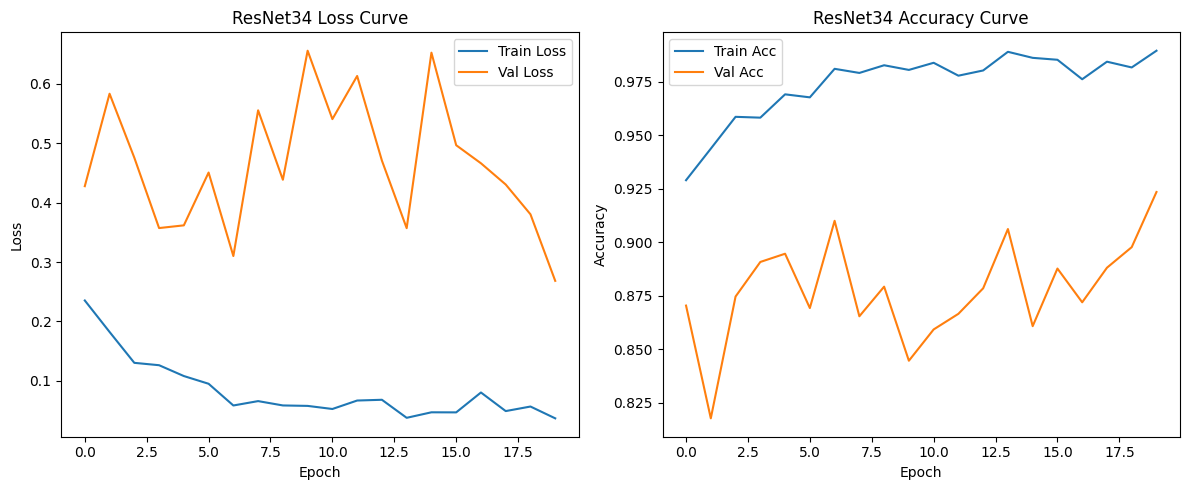

In [ ]:
# 5. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet34 Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Acc')
plt.plot(val_accs_resnet34, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet34 Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [31]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# 1. Set hyperparameters for the distillation process. 
MAX_EPOCH = 60  
INIT_LR = 0.0005  
BATCH_SIZE = 128  
NUM_WORKERS = 8  
PIN_MEMORY = True  
TEMPERATURE = 3.0  
LOSS_RATIO = 0.5   
WEIGHT_DECAY = 5e-4
EARLY_STOPPING_PATIENCE = 10  # Early stopping tolerance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
resnet18 = torchvision.models.resnet18(weights=None)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)
resnet18 = resnet18.to(device)

In [34]:
# Assuming num_classes and device are defined earlier in the code
num_classes = 10  # Example: set number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the saved ResNet34 and move the model to selected device.
resnet34 = torchvision.models.resnet34(weights=None)
in_features = resnet34.fc.in_features
resnet34.fc = nn.Linear(in_features, num_classes)
models_dir = os.path.abspath(os.path.join(os.getcwd(), '../models'))
resnet34.load_state_dict(torch.load(os.path.join(models_dir, 'resnet34_checkpoint.pkl'), map_location=device))
resnet34 = resnet34.to(device)
resnet34.eval()  # Teacher model in eval mode

C:\Users\novas\AppData\Local\Temp\ipykernel_13360\3064006315.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load(os.path.join(models_dir

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 4. Define the optimizer, loss function, etc.
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction='batchmean')  # For distillation
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

c:\Users\novas\miniconda3\envs\MSA\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
# 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'. (优化版)
# Knowledge distillation training loop
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []
best_val_acc = 0.0
best_model_wts = copy.deepcopy(resnet18.state_dict())
best_epoch = 0
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(MAX_EPOCH):
    resnet18.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # Student forward
        student_logits = resnet18(inputs)
        # Teacher forward (no grad)
        with torch.no_grad():
            teacher_logits = resnet34(inputs)
        # Distillation loss (KLDiv with softmax/temperature)
        log_student_soft = F.log_softmax(student_logits / TEMPERATURE, dim=1)
        teacher_soft = F.softmax(teacher_logits / TEMPERATURE, dim=1)
        loss_kd = kl_loss(log_student_soft, teacher_soft) * (TEMPERATURE ** 2)
        # Standard CE loss
        loss_ce = ce_loss(student_logits, labels)
        # Total loss
        loss = LOSS_RATIO * loss_kd + (1 - LOSS_RATIO) * loss_ce
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(student_logits, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    train_losses_resnet18.append(epoch_loss)
    train_accs_resnet18.append(epoch_acc)

    # Validation
    resnet18.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            student_logits = resnet18(inputs)
            loss = ce_loss(student_logits, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(student_logits, 1)
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_corrects / val_total
    val_losses_resnet18.append(val_epoch_loss)
    val_accs_resnet18.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    # 学习率调度
    scheduler.step(val_epoch_loss)

    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(resnet18.state_dict())
        best_epoch = epoch
        torch.save(best_model_wts, os.path.join(models_dir, 'resnet18_checkpoint.pkl'))
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Early stopping
    if val_epoch_loss < min_val_loss:
        min_val_loss = val_epoch_loss
    if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

# After training, load best weights
resnet18.load_state_dict(best_model_wts)
print(f"Best val acc: {best_val_acc:.4f} at epoch {best_epoch+1}")


Epoch 1/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]



Epoch 1/60 | Train Loss: 5.1873 Acc: 0.5371 | Val Loss: 2.6843 Acc: 0.5435


Epoch 2/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]



Epoch 2/60 | Train Loss: 3.4116 Acc: 0.6973 | Val Loss: 1.3618 Acc: 0.6892


Epoch 3/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


Epoch 3/60 | Train Loss: 2.7615 Acc: 0.7545 | Val Loss: 1.6224 Acc: 0.6669


Epoch 4/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]



Epoch 4/60 | Train Loss: 2.2766 Acc: 0.7923 | Val Loss: 1.1399 Acc: 0.7223


Epoch 5/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]



Epoch 5/60 | Train Loss: 1.9747 Acc: 0.8195 | Val Loss: 1.1078 Acc: 0.7377


Epoch 6/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]



Epoch 6/60 | Train Loss: 1.7388 Acc: 0.8378 | Val Loss: 0.8743 Acc: 0.7954


Epoch 7/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Epoch 7/60 | Train Loss: 1.5042 Acc: 0.8601 | Val Loss: 1.2175 Acc: 0.7173


Epoch 8/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


Epoch 8/60 | Train Loss: 1.2510 Acc: 0.8891 | Val Loss: 1.0795 Acc: 0.7762


Epoch 9/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch 9/60 | Train Loss: 1.1095 Acc: 0.9013 | Val Loss: 1.5734 Acc: 0.6965


Epoch 10/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 10/60 | Train Loss: 0.9636 Acc: 0.9178 | Val Loss: 1.2354 Acc: 0.7542


Epoch 11/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]


Epoch 11/60 | Train Loss: 0.8982 Acc: 0.9235 | Val Loss: 1.2928 Acc: 0.7615


Epoch 12/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


Epoch 12/60 | Train Loss: 0.7281 Acc: 0.9427 | Val Loss: 1.8803 Acc: 0.7258


Epoch 13/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]



Epoch 13/60 | Train Loss: 0.4077 Acc: 0.9758 | Val Loss: 0.6699 Acc: 0.8442


Epoch 14/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]



Epoch 14/60 | Train Loss: 0.2884 Acc: 0.9877 | Val Loss: 0.6194 Acc: 0.8569


Epoch 15/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch 15/60 | Train Loss: 0.2308 Acc: 0.9905 | Val Loss: 0.6765 Acc: 0.8435


Epoch 16/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


Epoch 16/60 | Train Loss: 0.1994 Acc: 0.9945 | Val Loss: 0.6629 Acc: 0.8550


Epoch 17/60 [Val]: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch 17/60 | Train Loss: 0.1730 Acc: 0.9950 | Val Loss: 0.7571 Acc: 0.8412


Epoch 18/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]



Epoch 18/60 | Train Loss: 0.1606 Acc: 0.9954 | Val Loss: 0.6160 Acc: 0.8588


Epoch 19/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]


Epoch 19/60 | Train Loss: 0.1636 Acc: 0.9969 | Val Loss: 0.7173 Acc: 0.8435


Epoch 20/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Epoch 20/60 | Train Loss: 0.1717 Acc: 0.9951 | Val Loss: 0.6081 Acc: 0.8569


Epoch 21/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]


Epoch 21/60 | Train Loss: 0.1664 Acc: 0.9944 | Val Loss: 0.8434 Acc: 0.8250


Epoch 22/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


Epoch 22/60 | Train Loss: 0.1607 Acc: 0.9945 | Val Loss: 0.7751 Acc: 0.8304


Epoch 23/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.37it/s]


Epoch 23/60 | Train Loss: 0.1427 Acc: 0.9968 | Val Loss: 0.6771 Acc: 0.8381


Epoch 24/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


Epoch 24/60 | Train Loss: 0.1536 Acc: 0.9946 | Val Loss: 0.7381 Acc: 0.8215


Epoch 25/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 25/60 | Train Loss: 0.1449 Acc: 0.9968 | Val Loss: 0.8604 Acc: 0.8246


Epoch 26/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.28it/s]


Epoch 26/60 | Train Loss: 0.1417 Acc: 0.9950 | Val Loss: 0.8629 Acc: 0.8304


Epoch 27/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]



Epoch 27/60 | Train Loss: 0.1201 Acc: 0.9971 | Val Loss: 0.5612 Acc: 0.8615


Epoch 28/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


Epoch 28/60 | Train Loss: 0.0991 Acc: 0.9988 | Val Loss: 0.5778 Acc: 0.8615


Epoch 29/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]



Epoch 29/60 | Train Loss: 0.0945 Acc: 0.9987 | Val Loss: 0.5730 Acc: 0.8619


Epoch 30/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]


Epoch 30/60 | Train Loss: 0.0956 Acc: 0.9977 | Val Loss: 0.5709 Acc: 0.8596


Epoch 31/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]



Epoch 31/60 | Train Loss: 0.0967 Acc: 0.9987 | Val Loss: 0.5653 Acc: 0.8662


Epoch 32/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


Epoch 32/60 | Train Loss: 0.0932 Acc: 0.9976 | Val Loss: 0.6463 Acc: 0.8454


Epoch 33/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]



Epoch 33/60 | Train Loss: 0.0850 Acc: 0.9990 | Val Loss: 0.5606 Acc: 0.8681


Epoch 34/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


Epoch 34/60 | Train Loss: 0.0871 Acc: 0.9978 | Val Loss: 0.5948 Acc: 0.8585


Epoch 35/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


Epoch 35/60 | Train Loss: 0.0831 Acc: 0.9985 | Val Loss: 0.5520 Acc: 0.8654


Epoch 36/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Epoch 36/60 | Train Loss: 0.0863 Acc: 0.9978 | Val Loss: 0.5731 Acc: 0.8650


Epoch 37/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.25it/s]


Epoch 37/60 | Train Loss: 0.0892 Acc: 0.9983 | Val Loss: 0.6123 Acc: 0.8623


Epoch 38/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


Epoch 38/60 | Train Loss: 0.0912 Acc: 0.9969 | Val Loss: 0.5819 Acc: 0.8642


Epoch 39/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Epoch 39/60 | Train Loss: 0.0917 Acc: 0.9982 | Val Loss: 0.5889 Acc: 0.8585


Epoch 40/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


Epoch 40/60 | Train Loss: 0.0877 Acc: 0.9981 | Val Loss: 0.5919 Acc: 0.8558


Epoch 41/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]


Epoch 41/60 | Train Loss: 0.0958 Acc: 0.9979 | Val Loss: 0.6490 Acc: 0.8523


Epoch 42/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]


Epoch 42/60 | Train Loss: 0.0754 Acc: 0.9987 | Val Loss: 0.5605 Acc: 0.8646


Epoch 43/60 [Val]: 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]

Epoch 43/60 | Train Loss: 0.0655 Acc: 0.9988 | Val Loss: 0.5333 Acc: 0.8662
Early stopping triggered at epoch 43.
Best val acc: 0.8681 at epoch 33


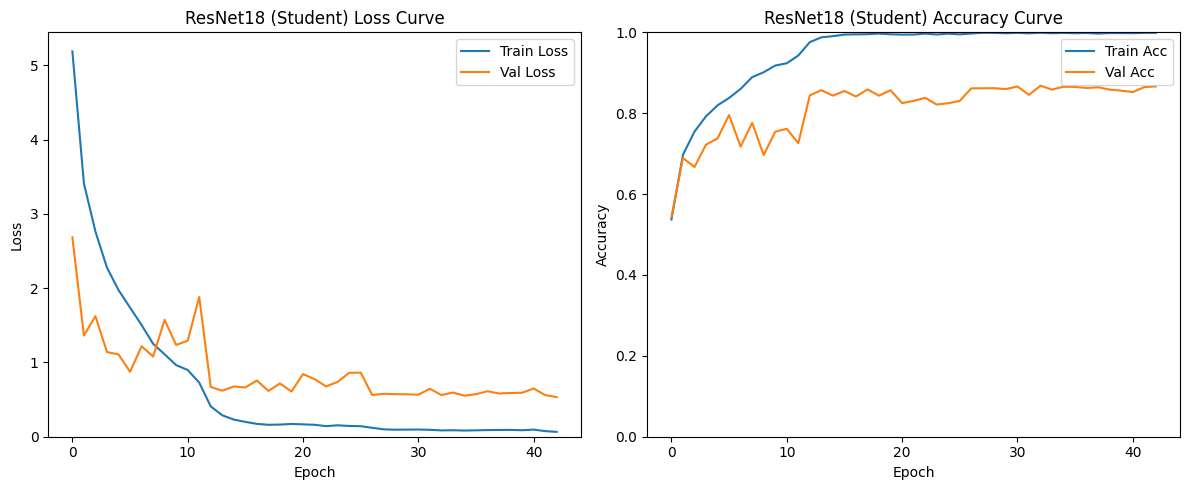

In [ ]:
# 6. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 (Student) Loss Curve')
plt.legend()
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Acc')
plt.plot(val_accs_resnet18, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 (Student) Accuracy Curve')
plt.legend()
plt.ylim(bottom=0, top=1)

plt.tight_layout()
plt.show()



# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# 1. Load the saved ResNet18 and move it to the selected device.
models_dir = os.path.abspath(os.path.join(os.getcwd(), '../models'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = torchvision.models.resnet18(weights=None)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)
resnet18.load_state_dict(torch.load(os.path.join(models_dir, 'resnet18_checkpoint.pkl'), map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()  # Evaluation mode


C:\Users\novas\AppData\Local\Temp\ipykernel_13360\1480213778.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load(os.path.join(models_dir,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 2. Do prediction using the images in the testing set.
from torch.utils.data import DataLoader
test_dataset = torch.utils.data.TensorDataset(tensor_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
predictions = []
with torch.no_grad():
    for (inputs,) in test_loader:
        inputs = inputs.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())


In [ ]:
# 3. Write the results into the CSV file for submission.
# The CSV file should be in the format of 'file_name' and 'label'.
submission_path = os.path.abspath(os.path.join(os.getcwd(), '../submission.csv'))
with open(submission_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['file_name', 'label'])
    for idx, pred in enumerate(predictions):
        label = index_to_label[pred]
        file_name = f"{idx}.jpg"
        writer.writerow([file_name, label])
print(f"Submission file saved to: {submission_path}")


Submission file saved to: d:\Projects2025\2025-Phase-2\data-science\3. Deep Learning Project\submission.csv
